In [5]:
%pip install "pybigwig==0.3.18"

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pybigwig' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pybigwig'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for pybigwig: filename=pybigwig-0.3.18-cp310-cp310-macosx_15_0_arm64.whl size=55603 sha256=f07d66c690e49e51b5fd2d80859ef4ab140371f79346148ab0fc94f5f7e23cdb
  Stored in directory: /Users/lauren_myers/Library/Caches/pip/wheels/52/b7/c8/46e207776c2bfcdd924bde3efb06982a014cd92eb52f19e869
Successfully built pybigwig
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confli

In [8]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import pybedtools
import csv
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("all packages loaded!")

all packages loaded!


In [9]:
%%bash

#Download model weights (data fold 3, 4 replicates)
for rep in f3c0,f0 f3c1,f1 f3c2,f2 f3c3,f3; do IFS=","; set -- $rep; 
  mkdir -p "saved_models/$1/train"
  local_model="saved_models/$1/train/model0_best.h5"
  if [ -f "$local_model" ]; then
    echo "$1 model already exists."
  else
    wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$2/model0_best.h5" -O "$local_model"
  fi
done

#Download and uncompress annotation files
mkdir -p hg38/genes/gencode41
mkdir -p hg38/genes/polyadb

if [ -f hg38/genes/gencode41/gencode41_basic_nort.gtf ]; then
  echo "Gene annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_nort.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_nort_protein.gtf ]; then
  echo "Gene annotation (no read-through, protein-coding) already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort_protein.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_nort_protein.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein.gtf ]; then
  echo "Gene annotation (protein-coding) already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_protein.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_tss2.bed ]; then
  echo "TSS annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_tss2.bed.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_tss2.bed
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice site annotation already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz -O hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein_splice.gff ]; then
  echo "Splice site annotation already exist."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.gff.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_protein_splice.gff
fi

if [ -f hg38/genes/polyadb/polyadb_human_v3.csv.gz ]; then
  echo "PolyA site annotation already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz -O hg38/genes/polyadb/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
mkdir -p hg38/assembly/ucsc

if [ -f hg38/assembly/ucsc/hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38/assembly/ucsc/hg38.fa
fi


f3c0 model already exists.
f3c1 model already exists.
f3c2 model already exists.
f3c3 model already exists.
Gene annotation already exists.
Gene annotation (no read-through, protein-coding) already exists.
Gene annotation (protein-coding) already exists.
TSS annotation already exists.
Splice site annotation already exist.
Splice site annotation already exist.
PolyA site annotation already exist.
Human genome FASTA already exists.


In [11]:
pyfaidx.Faidx('hg38/assembly/ucsc/hg38.fa')

Faidx("hg38/assembly/ucsc/hg38.fa")

In [12]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_reps = 1       #To use only one model replicate, set to 'n_reps = 1'. To use all four replicates, set 'n_reps = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Remove cropping
params_model['trunk'][-2]['cropping'] = 0

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for rep_ix in range(n_reps) :
    
    model_file = "saved_models/f3c" + str(rep_ix) + "/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


2025-11-09 19:33:57.244957: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-09 19:33:57.245237: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-09 19:33:57.245676: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-09 19:33:57.245998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-09 19:33:57.246811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
#Load genome fasta and gene annotations

#Initialize fasta sequence extractor
fasta_open = pysam.Fastafile('hg38/assembly/ucsc/hg38.fa')

#Load gene/exon annotation
gtf_file = 'hg38/genes/gencode41/gencode41_basic_nort_protein.gtf'

transcriptome = bgene.Transcriptome(gtf_file)

#Get gene span bedtool
bedt_span = transcriptome.bedtool_span()

#Load APA atlas
apa_df = pd.read_csv('hg38/genes/polyadb/polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df_utr = apa_df.query("site_type == '3\\' most exon'").copy().reset_index(drop=True)

#Or intronic sites
apa_df_intron = apa_df.query("site_type == 'Intron' and pas_type != 'No_CSE'").copy().reset_index(drop=True)

print("len(apa_df_utr) = " + str(len(apa_df_utr)))
print("len(apa_df_intron) = " + str(len(apa_df_intron)))

#Load TSS atlas
tss_df = pd.read_csv('hg38/genes/gencode41/gencode41_basic_tss2.bed', sep='\t', names=['chrom', 'position_hg38', 'end', 'tss_id', 'feat1', 'strand'])
tss_df['gene'] = tss_df['tss_id'].apply(lambda x: x.split("/")[1] if "/" in x else x)

print("len(tss_df) = " + str(len(tss_df)))


len(apa_df_utr) = 114605
len(apa_df_intron) = 83473
len(tss_df) = 116649


In [15]:
#Get reference/alternate sequence for variant, and annotations for target gene

search_gene = 'ENSG00000187164'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

load_isoforms = True

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]
gene_strand = gene.strand

if chrom is None or start is None or end is None :
    chrom = gene.chrom
    g_start, g_end = gene.span()
    mid = (g_start + g_end) // 2
    start = mid - seq_len // 2
    end = mid + seq_len // 2

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True)

#Get sequence bedtool
seq_bedt = pybedtools.BedTool('%s %d %d' % (chrom, start, end), from_string=True)

#Get all genes (exons and strands) overlapping input window
gene_ids = sorted(list(set([overlap[3] for overlap in bedt_span.intersect(seq_bedt, wo=True) if search_gene not in overlap[3]])))
gene_slices = []
gene_strands = []
for gene_id in gene_ids :
    gene_slices.append(transcriptome.genes[gene_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))
    gene_strands.append(transcriptome.genes[gene_id].strand)

#Get 3' UTR pA sites for gene
apa_df_gene_utr = apa_df_utr.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]
apa_df_gene_intron = apa_df_intron.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

#Get TSS sites for gene
tss_df_gene = tss_df.loc[tss_df['gene'].str.contains(search_gene)].copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

def _switch_transcript_id(id_str) :
    return id_str.replace("gene_id", "gene_id_orig").replace("transcript_id", "gene_id")

#Get gene isoforms
isoform_slices = None
if load_isoforms :
    gtf_df = pd.read_csv(gtf_file, sep='\t', skiprows=5, names=['chrom', 'havana_str', 'feature', 'start', 'end', 'feat1', 'strand', 'feat2', 'id_str'])
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains(search_gene)].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains("transcript_id")].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['feature'] == 'exon'].copy().reset_index(drop=True)
    
    transcript_ids = gtf_df['id_str'].apply(lambda x: x.split("transcript_id \"")[1].split("\";")[0]).unique().tolist()
    gtf_df['id_str'] = gtf_df['id_str'].apply(_switch_transcript_id)
    
    gtf_df.to_csv('borzoi_gene_isoforms.gtf', sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)
    
    transcriptome_iso = bgene.Transcriptome('borzoi_gene_isoforms.gtf')
    
    isoform_slices = []
    for transcript_id in transcript_ids :
        isoform_slices.append(transcriptome_iso.genes[transcript_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))


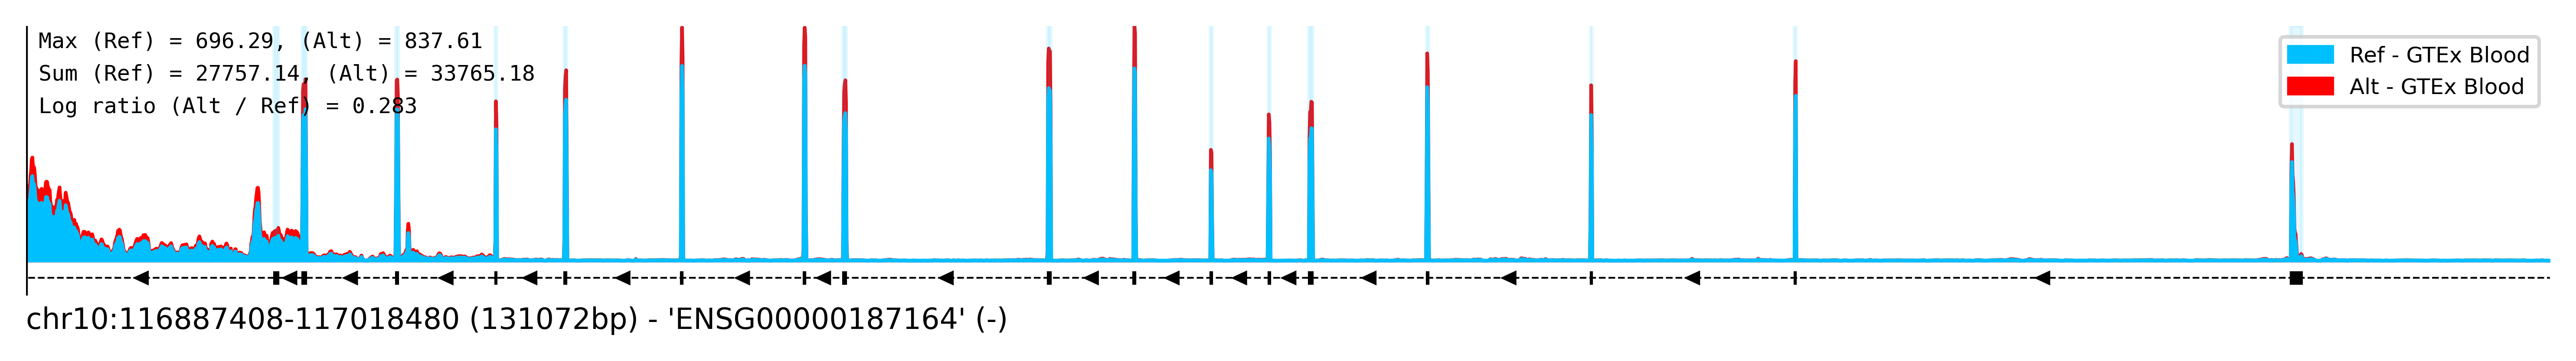

CPU times: user 21.4 s, sys: 16.6 s, total: 38 s
Wall time: 40.8 s


In [16]:
%%time
#Predict for chr10_116952944_T_C
# (~6 minutes on CPU w 1 replicate; ~2 minutes on GPU)

save_figs = False
save_suffix = '_chr10_116952944_T_C'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)


#Visualize coverage tracks
plot_start = seq_len // 2 - 131072 // 2
plot_end = seq_len // 2 + 131072 // 2
bin_size = 32
pad = 0

#Tracks
track_indices = [
    np.nonzero((targets_df['description'] == 'RNA:blood').values)[0].tolist(),
]

track_names = [
    'GTEx Blood',
]

track_colors = [
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Ref', 'Alt'],
]

track_scale = 0.01
track_transform = 3./4.
soft_clip = 384.

untransform_old = True

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[1, 0],
    pair_alpha=1.,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=False,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1.5),
    untransform_old=untransform_old,
)


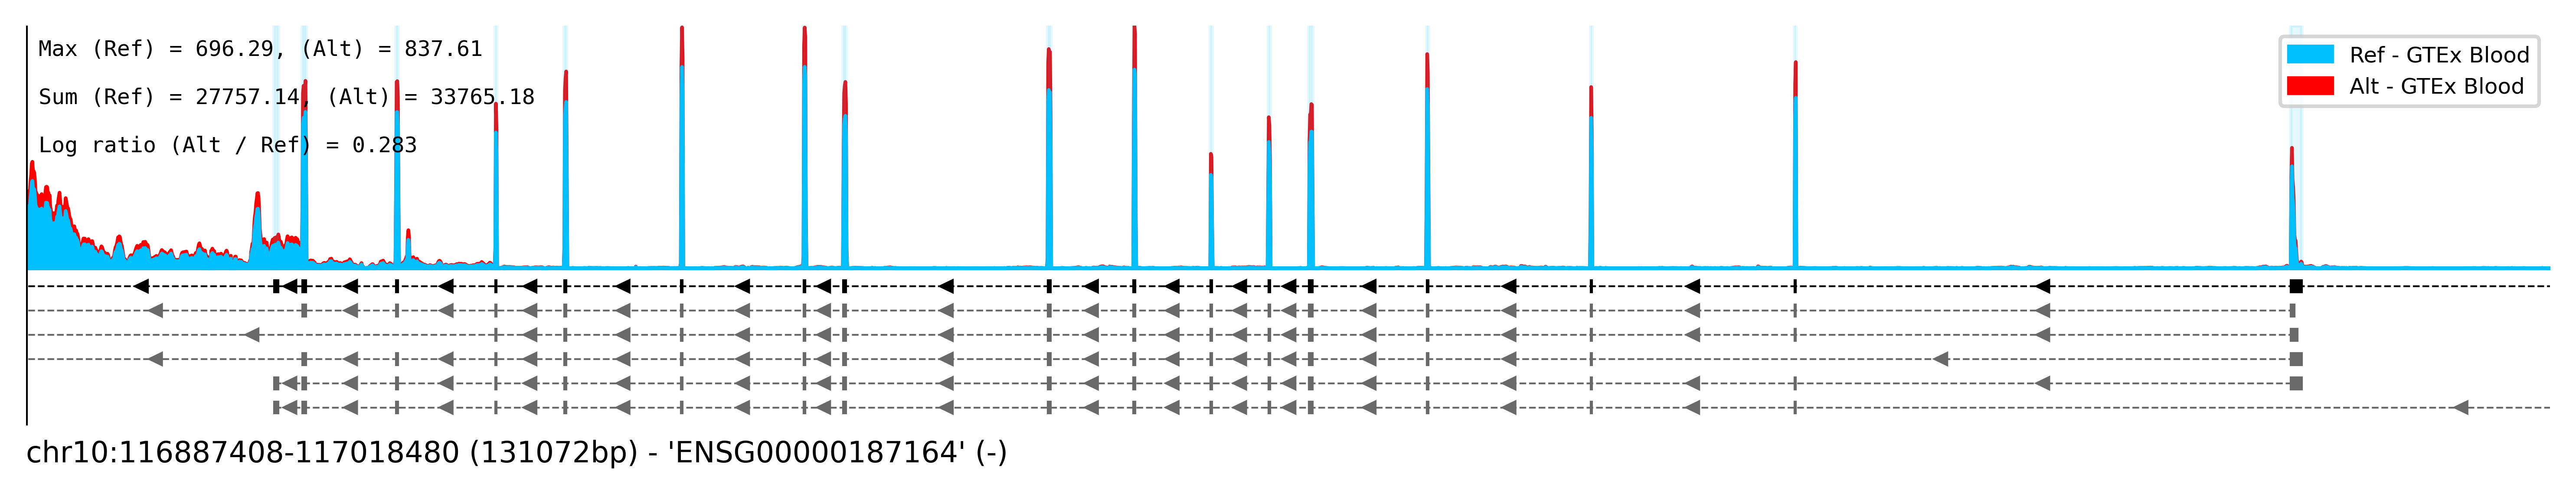

In [17]:
#Re-plot coverage tracks and annotate isoforms

plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[1, 0],
    pair_alpha=1.,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=False,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=True,
    plot_isoform_strands=True,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.5,
    plot_as_bars=False,
    fig_size=(10, 2),
    untransform_old=untransform_old,
)


In [18]:
%%time
#Get contribution scores (gradient) for blood GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=target_index[[9, 10, 11]].tolist(),
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_reps).tolist(),
    untransform_old=True,
)


2025-11-09 19:40:30.015344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 72s 72s/step
CPU times: user 19min 27s, sys: 3min 41s, total: 23min 9s
Wall time: 9min 26s


--- WT ---


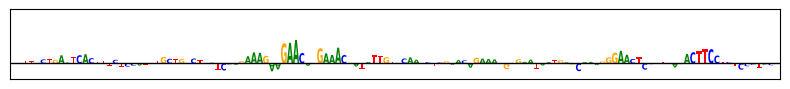

--- Mut ---


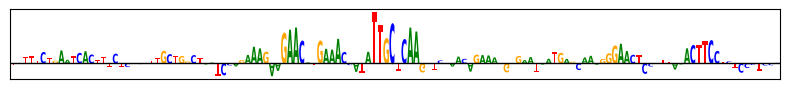

In [19]:
#Visualize gradient contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_blood'
)


In [20]:
%%time
#Get contribution scores (ISM) for blood GTEX tracks
# (not feasible to run on CPU; ~33 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0


--- WT ---


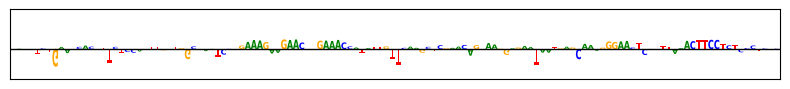

--- Mut ---


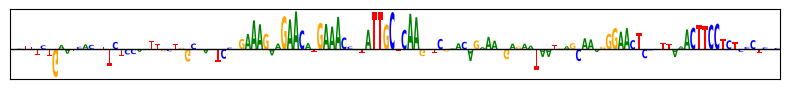

In [12]:
#Visualize ISM contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_blood'
)


In [13]:
%%time
#Get contribution scores (ISM shuffle) for blood GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    window_size=5,
    n_samples=12,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0
example_ix = 1
CPU times: user 48min 34s, sys: 9min 1s, total: 57min 35s
Wall time: 2h 15min


--- WT ---


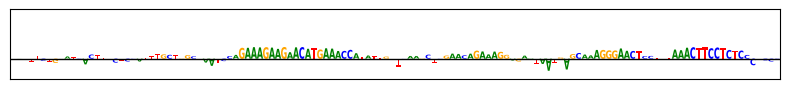

--- Mut ---


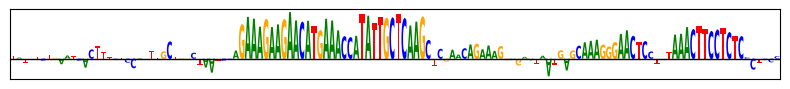

In [14]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_blood'
)


In [9]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16384, 32)
gtex_targets_mut.shape = (16384, 32)


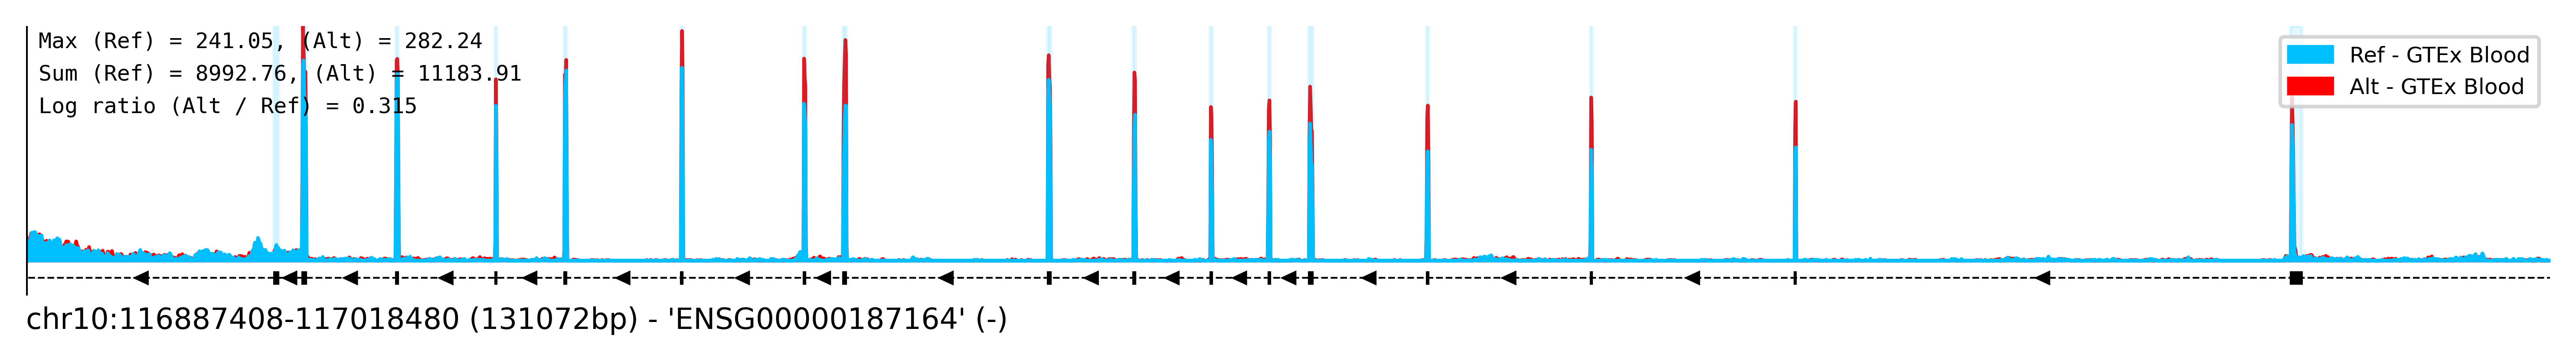

In [10]:
#Visualize measured coverage tracks for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C_meas_32_subjects'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 0, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 0, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01, transform_old=True)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01, transform_old=True)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

#Visualize coverage tracks
plot_start = seq_len // 2 - 131072 // 2
plot_end = seq_len // 2 + 131072 // 2
bin_size = 32
pad = 0

#Tracks
track_indices = [
    np.arange(gtex_targets_wt.shape[1], dtype='int32').tolist(),
]

track_names = [
    'GTEx Blood',
]

track_colors = [
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Ref', 'Alt'],
]

track_scale = 0.01
track_transform = 3./4.
soft_clip = 384.

untransform_old = True

#Plot coverage
plot_coverage_tracks(
    gtex_targets_wt[None, None, ...],
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=gtex_targets_mut[None, None, ...],
    plot_pair=True,
    pair_order=[1, 0],
    pair_alpha=1.,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    normalize_counts=True,
    normalize_start_rel=0 + pad * bin_size,
    normalize_end_rel=524288 - pad * bin_size,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=False,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1.5),
    untransform_old=untransform_old,
)
